Deep Learning
=============

Assignment 4
------------

Previously in `2_fullyconnected.ipynb` and `3_regularization.ipynb`, we trained fully connected networks to classify [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) characters.

The goal of this assignment is make the neural network convolutional.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

/home/dataimpact/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [3]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


In [4]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [5]:
#keras 
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

#neural network 
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.05
set_session(tf.Session(config=config))
import numpy as np
# import os
# os.environ["THEANO_FLAGS"] = "device=gpu0"
from keras.models import Model, Sequential
from keras.layers import Dense,Conv2D,MaxPool1D, MaxPooling2D, Dropout, Activation, LSTM, Input, merge, Reshape, Flatten, LocallyConnected1D, Embedding


Using TensorFlow backend.


In [12]:
from keras import optimizers, losses, utils, regularizers

train_set_size = 5000

input_layer = Input(shape=(28, 28, 1), name='input_image')

conv_layer1 = Conv2D(32, kernel_size=(5, 5), activation='relu', strides=(1,1))(input_layer)
conv_layer1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv_layer1)
conv_layer2 = Conv2D(64, kernel_size=(5, 5), strides=(1, 1), activation = 'relu')(conv_layer1)
conv_layer2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(conv_layer2)

f_layer = Flatten()(conv_layer2)
hidden_layer = Dense(units=1000, activation='relu')(f_layer)
hidden_layer = Dropout(0.5)(hidden_layer)
output = Dense(units=10, activation='softmax', name='main_output')(hidden_layer)

model = Model(input=input_layer, output=output)

model.compile(optimizer='adam', loss='categorical_crossentropy',  metrics=['categorical_accuracy'])

one_hot_train_labels = utils.to_categorical(train_labels, num_classes=10)



/home/dataimpact/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ma...)`


In [15]:
train_size = 60000
model.fit(train_dataset[:train_size, :, :], train_labels[:train_size], epochs=10)


Epoch 1/10
60000/60000 [==============================] - 55s 922us/step - loss: 0.4169 - categorical_accuracy: 0.8780
Epoch 2/10
60000/60000 [==============================] - 53s 885us/step - loss: 0.3621 - categorical_accuracy: 0.8920
Epoch 3/10
60000/60000 [==============================] - 61s 1ms/step - loss: 0.3306 - categorical_accuracy: 0.9000
Epoch 4/10
60000/60000 [==============================] - 64s 1ms/step - loss: 0.3088 - categorical_accuracy: 0.9068
Epoch 5/10
60000/60000 [==============================] - 73s 1ms/step - loss: 0.2914 - categorical_accuracy: 0.9110
Epoch 6/10
60000/60000 [==============================] - 77s 1ms/step - loss: 0.2765 - categorical_accuracy: 0.9157
Epoch 7/10
60000/60000 [==============================] - 76s 1ms/step - loss: 0.2633 - categorical_accuracy: 0.9199
Epoch 8/10
60000/60000 [==============================] - 76s 1ms/step - loss: 0.2511 - categorical_accuracy: 0.9230
Epoch 9/10
60000/60000 [==============================] - 79

In [16]:
model.evaluate(test_dataset, test_labels)

10000/10000 [==============================] - 3s 304us/step


[0.14178905156180263, 0.9565]

predicted D, actual D


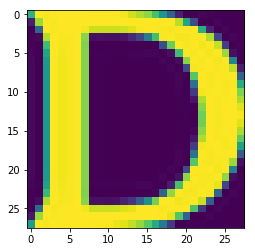

In [224]:
import matplotlib.pyplot as plt
classes = "ABCDEFGHIJ"
rd = np.random.randint(len(test_dataset))
print("predicted {}, actual {}".format(classes[model.predict(test_dataset[rd, :, :].reshape(1,28,28,1)).argmax()], classes[test_labels[rd].argmax()]))

plt.imshow(test_dataset[rd, :, :].reshape(28,28))